In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt
import skimage.transform as st

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, groutine, crystal

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------

energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=100.,
                              sigma_y=100.,
                              sigma_z=1.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)      # This is the deviation angle.

grating_list = [crystal.SinusoidalPhaseGrating(), crystal.SinusoidalPhaseGrating()]
grating_list[0].set_period(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0))
grating_list[1].set_period(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0))

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay
# ----------------------------------------------------------------------------------------------------------

# Some meta data for the delay line.
reflect_num = 4
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length, ] * reflect_num)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta
bragg_angle_1 = np.radians(18.836) + 13e-6

branch_angle_1 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_1,
                                                theta=bragg_angle_1 + np.pi / 2. ,
                                                rho=bragg_angle_1 - np.pi / 2. ,
                                                inclined_angle=np.radians(10.))
surface_points_1 = np.zeros((reflect_num, 3), dtype=np.float64)

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_1[0],
                                           rho_vals=branch_angle_1[1],
                                           tau_vals=branch_angle_1[2],
                                           surface_points=surface_points_1,
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg_angle_2 = np.radians(18.836) + 13e-6

branch_angle_2 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_2,
                                                theta=1.5 * np.pi - bragg_angle_2,
                                                rho=0.5 * np.pi - bragg_angle_2)
surface_points_2 = np.zeros((reflect_num, 3), dtype=np.float64)

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_2[0],
                                           rho_vals=branch_angle_2[1],
                                           tau_vals=branch_angle_2[2],
                                           surface_points=surface_points_2,
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))


# ----------------------------------------------------------------------------------------------------------
#                       Step 4: Arrange the crystals
# ----------------------------------------------------------------------------------------------------------
path_list_1 = [5e6 - 10e4, 1e5, 5e5,
               1.05e5, 6e6, 1e6]
path_list_2 = [5e6, 1e5, 1e5,
               1.05e5, 6e6, 1e6]
delay_time = 100.

# Adjust the path sections
(path_list_1,
 path_list_2) = lclsutil.get_split_delay_configuration(delay_time=delay_time,
                                                       fix_branch_path = path_list_2, 
                                                       var_branch_path= path_list_1,
                                                       fix_branch_crystal = crystal_list_2, 
                                                       var_branch_crystal = crystal_list_1,
                                                       grating_pair=grating_list,
                                                       pulse_obj=my_pulse)

(intersect_brunch_1,
 kout_brunch_1,
 intersect_brunch_2,
 kout_brunch_2) = lclsutil.get_light_path(pulse_obj=my_pulse,
                                          grating_list=grating_list,
                                          crystal_list_1=crystal_list_1,
                                          path_list_1=path_list_1,
                                          crystal_list_2=crystal_list_2,
                                          path_list_2=path_list_2)

# Initialize the delay line crystals
crystal_list_1 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_1[0],
                                           rho_vals=branch_angle_1[1],
                                           tau_vals=branch_angle_1[2],
                                           surface_points=np.copy(intersect_brunch_1[1:5]),
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))
# Initialize the delay line crystals
crystal_list_2 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_2[0],
                                           rho_vals=branch_angle_2[1],
                                           tau_vals=branch_angle_2[2],
                                           surface_points=np.copy(intersect_brunch_2[1:5]),
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))

# Initialize the gratings.
grating_list[0].set_surface_point(np.copy(intersect_brunch_1[0]))
grating_list[1].set_surface_point(np.copy(intersect_brunch_1[-2]))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_brunch_2[-2])

total_path = pre_length + util.get_total_path_length(intersection_point_list=intersect_brunch_2[:-1])
print("The total propagation length is {:.2f}m.".format(total_path/1e6))
                                    
#"""
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 500
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = lclsutil.get_k_mesh_3d(number_x=number_x,
                                                              number_y=number_y,
                                                              number_z=number_z,
                                                              delta_e_x=1e-50,
                                                              delta_e_y=3e-4,
                                                              delta_e_z=3e-4)
kz_grid += my_pulse.klen0

# Apply fft shift
#kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

The total propagation length is 11.23m.


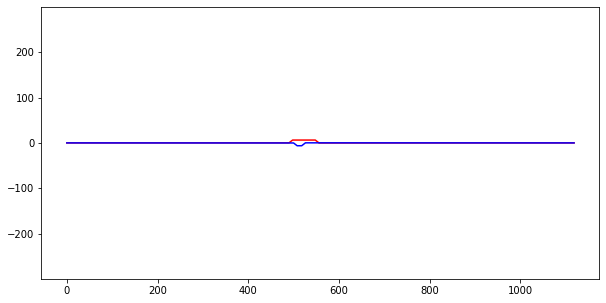

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_brunch_1[:,2]/1e4, intersect_brunch_1[:,1]/1e4,'r')
axes.plot(intersect_brunch_2[:,2]/1e4, intersect_brunch_2[:,1]/1e4,'b')

#axes.set_xlim([5e2-70, 5e2 + 150])
#axes.set_ylim([-0.1, 0.1])
axes.set_aspect('equal', 'datalim')

plt.show()

In [4]:
# Set the range of the index to save
z_idx_range = 500
num1 = 450
num2 = 50
d_num = 512

# -------------------------------------------------------------
#            Get Field for Branch 1
# -------------------------------------------------------------
(my_pulse, 
 crystal_list_1,
 crystal_list_2,
 grating_list, 
 obvservation,
 rot_mat_dict)= lclsutil.get_split_delay_output_frame_refined(kin=my_pulse.k0,
                                                      kout=kout_brunch_1[-2],
                                                      aux = np.array([1., 0., 0.], dtype=np.float64),
                                                      displacement=-np.copy(intersect_brunch_1[-2]),
                                                      observation=observation,
                                                      pulse=my_pulse,
                                                      crystal_list_1=crystal_list_1,
                                                      crystal_list_2=crystal_list_2,
                                                      grating_pair=grating_list)


grating_list[0].set_order(1)
grating_list[1].set_order(-1)


tic = time.time()

(result_3d_dict_1,
 result_2d_dict_1,
 check_dict_1) = groutine.get_single_branch_split_delay_field_before_grating2(grating_pair=grating_list,
                                                                              channel_cuts=crystal_list_1,
                                                                              total_path=total_path,
                                                                              observation=observation,
                                                                              my_pulse=my_pulse,
                                                                              kx_grid=kx_grid,
                                                                              ky_grid=ky_grid,
                                                                              kz_grid=kz_grid,
                                                                              delay_time=delay_time,
                                                                              number_x=number_x,
                                                                              number_y=number_y,
                                                                              number_z=number_z,
                                                                              z_idx_range=z_idx_range,
                                                                              num1=num1,
                                                                              num2=num2,
                                                                              d_num=512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

# -------------------------------------------------------------
#            Get Field for Branch 2
# -------------------------------------------------------------

grating_list[0].set_order(-1)
grating_list[1].set_order(1)


tic = time.time()

(result_3d_dict_2,
 result_2d_dict_2,
 check_dict_2) = groutine.get_single_branch_split_delay_field_before_grating2(grating_pair=grating_list,
                                                                              channel_cuts=crystal_list_2,
                                                                              total_path=total_path,
                                                                              observation=observation,
                                                                              my_pulse=my_pulse,
                                                                              kx_grid=kx_grid,
                                                                              ky_grid=ky_grid,
                                                                              kz_grid=kz_grid,
                                                                              delay_time=delay_time,
                                                                              number_x=number_x,
                                                                              number_y=number_y,
                                                                              number_z=number_z,
                                                                              z_idx_range=z_idx_range,
                                                                              num1=num1,
                                                                              num2=num2,
                                                                              d_num=512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 2.".format(toc - tic))

It takes 0.05 seconds to prepare the variables.
It takes 20.87 seconds to get the field for branch 1.
It takes 0.05 seconds to prepare the variables.
It takes 20.66 seconds to get the field for branch 2.


In [5]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------

energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=100.,
                              sigma_y=100.,
                              sigma_z=1.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)      # This is the deviation angle.

grating_list = [crystal.SinusoidalPhaseGrating(), crystal.SinusoidalPhaseGrating()]
grating_list[0].set_period(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0))
grating_list[1].set_period(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0))

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay
# ----------------------------------------------------------------------------------------------------------

# Some meta data for the delay line.
reflect_num = 4
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length, ] * reflect_num)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta
bragg_angle_1 = np.radians(18.836) + 13e-6

branch_angle_1 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_1,
                                                theta=bragg_angle_1 + np.pi / 2. ,
                                                rho=bragg_angle_1 - np.pi / 2. ,
                                                inclined_angle=np.radians(10.))
surface_points_1 = np.zeros((reflect_num, 3), dtype=np.float64)

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_1[0],
                                           rho_vals=branch_angle_1[1],
                                           tau_vals=branch_angle_1[2],
                                           surface_points=surface_points_1,
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg_angle_2 = np.radians(18.836) + 13e-6

branch_angle_2 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_2,
                                                theta=1.5 * np.pi - bragg_angle_2,
                                                rho=0.5 * np.pi - bragg_angle_2)
surface_points_2 = np.zeros((reflect_num, 3), dtype=np.float64)

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_2[0],
                                           rho_vals=branch_angle_2[1],
                                           tau_vals=branch_angle_2[2],
                                           surface_points=surface_points_2,
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))


# ----------------------------------------------------------------------------------------------------------
#                       Step 4: Arrange the crystals
# ----------------------------------------------------------------------------------------------------------
path_list_1 = [5e6 - 10e4, 1e5, 5e5,
               1.05e5, 6e6, 1e6]
path_list_2 = [5e6, 1e5, 1e5,
               1.05e5, 6e6, 1e6]
delay_time = 0.

# Adjust the path sections
(path_list_1,
 path_list_2) = lclsutil.get_split_delay_configuration(delay_time=delay_time,
                                                       fix_branch_path = path_list_2, 
                                                       var_branch_path= path_list_1,
                                                       fix_branch_crystal = crystal_list_2, 
                                                       var_branch_crystal = crystal_list_1,
                                                       grating_pair=grating_list,
                                                       pulse_obj=my_pulse)

(intersect_brunch_1,
 kout_brunch_1,
 intersect_brunch_2,
 kout_brunch_2) = lclsutil.get_light_path(pulse_obj=my_pulse,
                                          grating_list=grating_list,
                                          crystal_list_1=crystal_list_1,
                                          path_list_1=path_list_1,
                                          crystal_list_2=crystal_list_2,
                                          path_list_2=path_list_2)

# Initialize the delay line crystals
crystal_list_1 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_1[0],
                                           rho_vals=branch_angle_1[1],
                                           tau_vals=branch_angle_1[2],
                                           surface_points=np.copy(intersect_brunch_1[1:5]),
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))
# Initialize the delay line crystals
crystal_list_2 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_2[0],
                                           rho_vals=branch_angle_2[1],
                                           tau_vals=branch_angle_2[2],
                                           surface_points=np.copy(intersect_brunch_2[1:5]),
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))

# Initialize the gratings.
grating_list[0].set_surface_point(np.copy(intersect_brunch_1[0]))
grating_list[1].set_surface_point(np.copy(intersect_brunch_1[-2]))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_brunch_2[-2])

total_path = pre_length + util.get_total_path_length(intersection_point_list=intersect_brunch_2[:-1])
print("The total propagation length is {:.2f}m.".format(total_path/1e6))
                                    
#"""
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 500
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = lclsutil.get_k_mesh_3d(number_x=number_x,
                                                              number_y=number_y,
                                                              number_z=number_z,
                                                              delta_e_x=1e-50,
                                                              delta_e_y=3e-4,
                                                              delta_e_z=3e-4)
kz_grid += my_pulse.klen0

# Apply fft shift
#kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

# Set the range of the index to save
z_idx_range = 500
num1 = 450
num2 = 50
d_num = 512

# -------------------------------------------------------------
#             Go to the propoer frame
# -------------------------------------------------------------
(my_pulse, 
 crystal_list_1,
 crystal_list_2,
 grating_list, 
 obvservation,
 rot_mat_dict)= lclsutil.get_split_delay_output_frame_refined(kin=my_pulse.k0,
                                                      kout=kout_brunch_2[-2],
                                                      aux = np.array([1., 0., 0.], dtype=np.float64),
                                                      displacement=-np.copy(intersect_brunch_1[-2]),
                                                      observation=observation,
                                                      pulse=my_pulse,
                                                      crystal_list_1=crystal_list_1,
                                                      crystal_list_2=crystal_list_2,
                                                      grating_pair=grating_list)

# -------------------------------------------------------------
#            Get Field for Branch 2
# -------------------------------------------------------------

grating_list[0].set_order(-1)
grating_list[1].set_order(1)


tic = time.time()

(result_3d_dict_2,
 result_2d_dict_2,
 check_dict_2) = groutine.get_single_branch_split_delay_field_before_grating2(grating_pair=grating_list,
                                                                              channel_cuts=crystal_list_2,
                                                                              total_path=total_path,
                                                                              observation=observation,
                                                                              my_pulse=my_pulse,
                                                                              kx_grid=kx_grid,
                                                                              ky_grid=ky_grid,
                                                                              kz_grid=kz_grid,
                                                                              delay_time=delay_time,
                                                                              number_x=number_x,
                                                                              number_y=number_y,
                                                                              number_z=number_z,
                                                                              z_idx_range=z_idx_range,
                                                                              num1=num1,
                                                                              num2=num2,
                                                                              d_num=512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 2.".format(toc - tic))

The total propagation length is 11.23m.
It takes 0.06 seconds to prepare the variables.
It takes 20.79 seconds to get the field for branch 2.


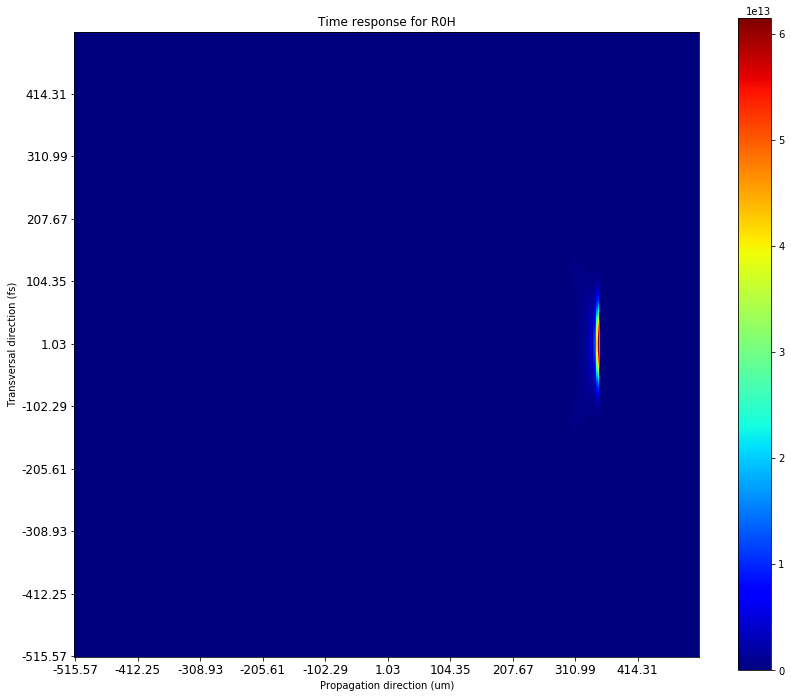

In [6]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_1 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_1['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.abs( field_1 ),
                 #vmin=  2.5,
                 #vmax = 12.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_xlabel("Propagation direction (um)")
axes.set_ylabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

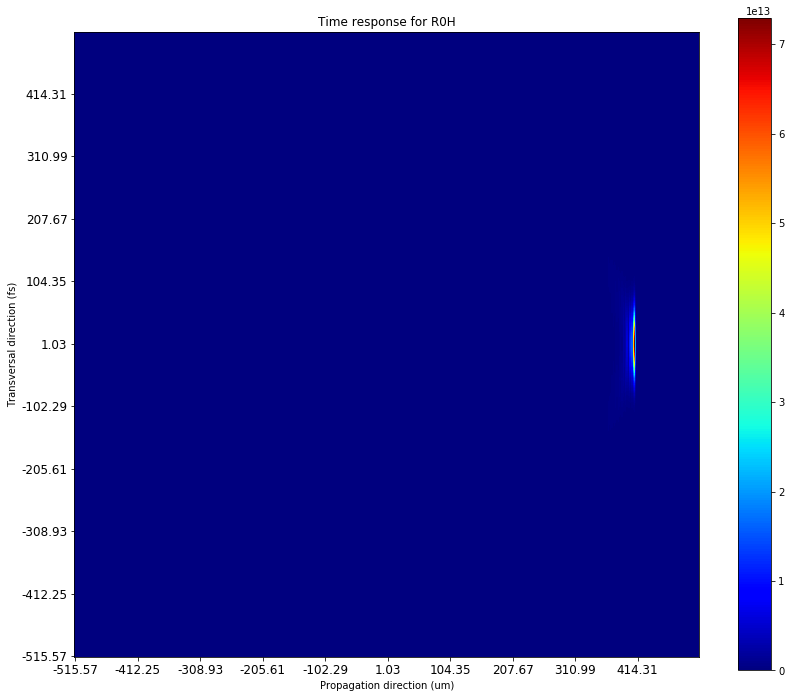

In [7]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_2 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_2['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.abs(field_2),
                 #vmin=  2.5,
                 #vmax = 12.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_xlabel("Propagation direction (um)")
axes.set_ylabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

# Rotate the crystal

In [8]:
################################################################
#            Rotate vector fields
################################################################
rot_angle_1 = - np.arccos(np.dot(kout_brunch_1[-2], np.array([0.,0.,1.])) /
                          np.linalg.norm(kout_brunch_1[-2]))

field_1_proj = np.multiply(complex(np.cos(rot_angle_1)), 
                              np.fft.ifftshift(np.fft.ifft(result_2d_dict_1['y_field_2d'], axis=0), axes=0))


rot_angle_2 = np.arccos(np.dot(kout_brunch_2[-2], np.array([0.,0.,1.])) /
                          np.linalg.norm(kout_brunch_2[-2]))

field_2_proj = np.multiply(complex(np.cos(rot_angle_2)), 
                              np.fft.ifftshift(np.fft.ifft(result_2d_dict_2['y_field_2d'], axis=0), axes=0))

################################################################
#            Get rotation matrix
################################################################
rot_mat_1 = np.array([[np.cos(rot_angle_1), - np.sin(rot_angle_1)],
                      [np.sin(rot_angle_1),   np.cos(rot_angle_1)]])

rot_mat_2 = np.array([[np.cos(rot_angle_2), -np.sin(rot_angle_2)],
                      [np.sin(rot_angle_2), np.cos(rot_angle_2)]])

In [9]:
################################################################
#            Get scaling factor
################################################################
scaling_mat = np.array([[axis_info["y_idx"][1] - axis_info["y_idx"][0], 0.],
                        [0., axis_info["z_idx"][1] - axis_info["z_idx"][0]]])

scaling_mat_inv = np.linalg.inv(scaling_mat)

################################################################
#            Add scaling factor to field 1
################################################################
scaled_field_1_real = st.rescale(field_1_proj.real,
                            (axis_info["y_idx"][1] - axis_info["y_idx"][0],
                             axis_info["z_idx"][1] - axis_info["z_idx"][0]),
                            order=1,
                            mode='reflect',
                            cval=0, 
                            clip=True,
                            preserve_range=False,
                            multichannel=False, 
                            anti_aliasing=True, 
                            anti_aliasing_sigma=None)

scaled_field_1_imag = st.rescale(field_1_proj.imag,
                            (axis_info["y_idx"][1] - axis_info["y_idx"][0],
                             axis_info["z_idx"][1] - axis_info["z_idx"][0]),
                            order=1,
                            mode='reflect',
                            cval=0, 
                            clip=True,
                            preserve_range=False,
                            multichannel=False, 
                            anti_aliasing=True, 
                            anti_aliasing_sigma=None)

scaled_field_1 = scaled_field_1_real + 1.j * scaled_field_1_imag

################################################################
#            Add scaling factor to field 2
################################################################
scaled_field_2_real = st.rescale(field_2_proj.real,
                            (axis_info["y_idx"][1] - axis_info["y_idx"][0],
                             axis_info["z_idx"][1] - axis_info["z_idx"][0]),
                            order=1,
                            mode='reflect',
                            cval=0, 
                            clip=True,
                            preserve_range=False,
                            multichannel=False, 
                            anti_aliasing=True, 
                            anti_aliasing_sigma=None)

scaled_field_2_imag = st.rescale(field_2_proj.imag,
                            (axis_info["y_idx"][1] - axis_info["y_idx"][0],
                             axis_info["z_idx"][1] - axis_info["z_idx"][0]),
                            order=1,
                            mode='reflect',
                            cval=0, 
                            clip=True,
                            preserve_range=False,
                            multichannel=False, 
                            anti_aliasing=True, 
                            anti_aliasing_sigma=None)

scaled_field_2 = scaled_field_2_real + 1.j * scaled_field_2_imag

################################################################
#            Get rotation center
################################################################
# The center of the delayed branch pulse is the rotation center.
# because it's the observation point and the point around which 
# we have rotated the crystals
index_max = np.unravel_index(np.argmax(np.abs(scaled_field_2)), scaled_field_2.shape)

################################################################
#            Get rotation center
################################################################
rotate_field_2_real = st.rotate(image=scaled_field_2_real,
                                angle=rot_angle_2,
                                resize=False,
                                center=None,
                                order=1,
                                mode='constant',
                                cval=0,
                                clip=True,
                                preserve_range=False)

rotate_field_2_imag = st.rotate(image=scaled_field_2_imag,
                                angle=rot_angle_2,
                                resize=False,
                                center=None,
                                order=1,
                                mode='constant',
                                cval=0,
                                clip=True,
                                preserve_range=False)

rotate_field_2 = rotate_field_2_real + 1.j * rotate_field_2_imag


rotate_field_1_real = st.rotate(image=scaled_field_1_real,
                                angle=rot_angle_1,
                                resize=False,
                                center=None,
                                order=1,
                                mode='constant',
                                cval=0,
                                clip=True,
                                preserve_range=False)

rotate_field_1_imag = st.rotate(image=scaled_field_1_imag,
                                angle=rot_angle_1,
                                resize=False,
                                center=None,
                                order=1,
                                mode='constant',
                                cval=0,
                                clip=True,
                                preserve_range=False)

rotate_field_1 = rotate_field_1_real + 1.j * rotate_field_1_imag


TypeError: Image data of dtype complex128 cannot be converted to float

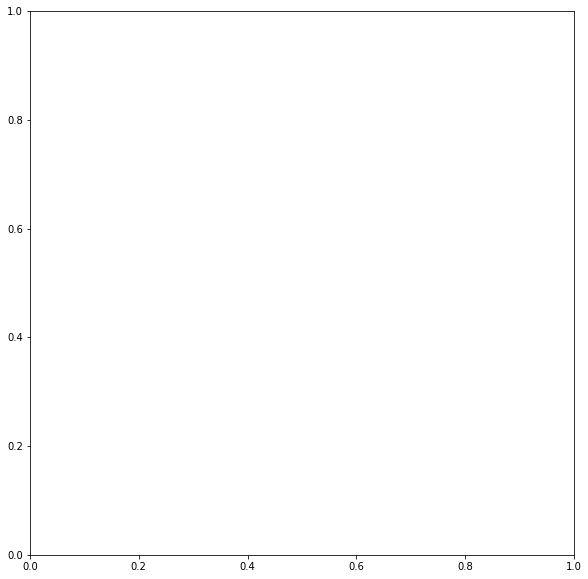

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(rotate_field_2)
plt.show()

In [ ]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)


im = axes.imshow(np.abs( field_1 + field_2 )[:,:450],
                 #vmin=  2.5,
                 #vmax = 12.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_xlabel("Propagation direction (um)")
axes.set_ylabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()